<a href="https://colab.research.google.com/github/ArturoMaiani/Master-Thesis---Pixies/blob/main/Unicycle_multi_point_interpolation_and_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math 
import numpy as np
import matplotlib.pyplot as plt

# Calcolo dell'ETSP

This Part takes as parameter N, the number of points to be interpolated. In this case those coordinates are chosen randomly in [-4,4]x[0,4]

Then the Euclidean Traveling salesman problem can be solved for just 4 points, which is very easy.

With the command:" print('path: {0}, length: {1}'.format(shortest, path_len(shortest))) " the code will print something like " path: [0, 2, 1, 3, 0], length: 14.589145361779925 " indicating which path is the optimum one.

In addition to that, given that those points must be interpolated with a unicycle, some orientations are defined a priori and then plotted in order to see if the ordering makes sense.

path: [0, 2, 1, 3, 0], length: 14.589145361779925


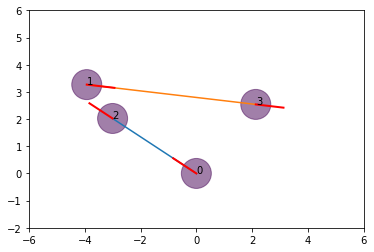

In [20]:

# Number of interpolated points
N=4

graph=np.zeros((N,N))
X=np.random.uniform(-4,4,N-1)
X=np.concatenate((np.zeros(1),X))
Y=np.random.uniform(0,4,N-1)
Y=np.concatenate((np.zeros(1),Y))

colors = [0 for i in range(N)]
area = (30 * 1)**2  

fig, ax = plt.subplots()
plt.scatter(X, Y, s=area, c=colors, alpha=0.5)
plt.xlim([-6, 6])
plt.ylim([-2, 6])

n = range(N)
for i, txt in enumerate(n):
    ax.annotate(txt, (X[i], Y[i]))

for i in range(1,N):
    for j in range(0,i):
            graph[i][j]=(((X[i])-X[j])**2+(Y[i]-Y[j])**2)**(0.5)
dist=graph+graph.T
# Helper function to calculate path length
def path_len(path):
    return sum(dist[i][j] for i, j in zip(path, path[1:]))

# Set of all nodes to visit
to_visit = set(range(len(dist)))

# Current state {(node, visited_nodes): shortest_path}
state = {(i, frozenset([0, i])): [0, i] for i in range(1, len(dist[0]))}

for _ in range(len(dist) - 2):
    next_state = {}
    for position, path in state.items():
        current_node, visited = position

        # Check all nodes that haven't been visited so far
        for node in to_visit - visited:
            new_path = path + [node]
            new_pos = (node, frozenset(new_path))

            # Update if (current node, visited) is not in next state or we found shorter path
            if new_pos not in next_state or path_len(new_path) < path_len(next_state[new_pos]):
                next_state[new_pos] = new_path

    state = next_state

# Find the shortest path from possible candidates
shortest = min((path + [0] for path in state.values()), key=path_len)
print('path: {0}, length: {1}'.format(shortest, path_len(shortest)))
theta_=[0 for i in range(len(shortest))]

for i in range(len(shortest)-1):
    if i%2==0:
        vecio=shortest[i]
        nuovo=shortest[i+1]
        norm=((X[nuovo]-X[vecio])**2+(Y[nuovo]-Y[vecio])**2)**(0.5)
        theta_[i:i+1]=[math.atan2(Y[nuovo]-Y[vecio],X[nuovo]-X[vecio]),math.atan2(Y[nuovo]-Y[vecio],X[nuovo]-X[vecio])]
        plt.plot([X[vecio], X[nuovo]],[Y[vecio], Y[nuovo]])
        plt.plot([X[vecio], X[vecio]+(X[nuovo]-X[vecio])/norm], [Y[vecio], Y[vecio]+(Y[nuovo]-Y[vecio])/norm], linewidth=2,color='red')
        plt.plot([X[nuovo], X[nuovo]+(X[nuovo]-X[vecio])/norm], [Y[nuovo], Y[nuovo]+(Y[nuovo]-Y[vecio])/norm], linewidth=2,color='red')
theta_=theta_[0:6]

# Tracking and interpolation


This part contains the function: interpolate(x_i,y_i,tet_i,x_f,y_f,tet_f,T,discretizations,jjj) , which generates a cubic interpolation between initial state space configuration and final one with a certain timing law given by parameter T. The interpolation is returned as a list of length, discretizations, since the original profile was continuous but we need to discretize it in order to plot.

Then the second part concerns a classical trajectory tracking problem.

This part will output three graphs:

1) The linear velocity profile for each trajectory

2) The interpolated curves and corresponding tracking

3) The angular velocity profile for each trajectory

As one can see, since a uniform time scaling solution has been developed, the bounds for the linear velocity never exceed 0.5 m/s and also the ngular velocity is bounded between -0.5 and 0.5 rad/s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


400 1 1 400


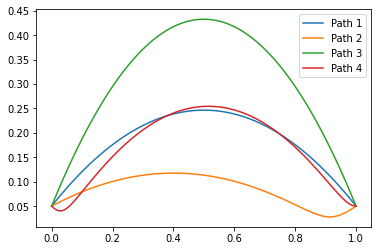

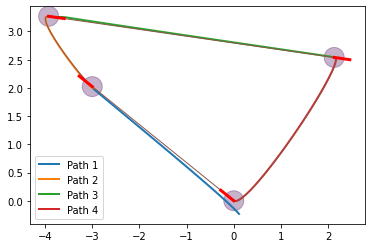

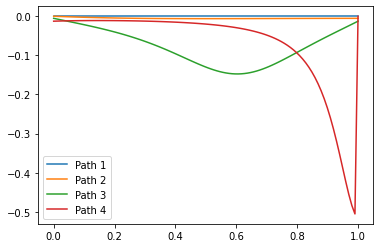

In [36]:
fig0,ax0=plt.subplots()
fig1,ax1=plt.subplots()
fig2,ax2=plt.subplots()
def interpolate(x_i,y_i,tet_i,x_f,y_f,tet_f,T,discretizations,jjj):
    factor=1
    s=np.linspace(0,1,discretizations)# sarebbe il rapporto tra t/T
    i=0
    K=1
    alpha_x=K*np.cos(tet_f)-3*x_f
    alpha_y=K*np.sin(tet_f)-3*y_f

    beta_x=K*np.cos(tet_i)+3*x_i
    beta_y=K*np.sin(tet_i)+3*y_i

    x=-(s-1)**3*x_i+s**3*x_f+alpha_x*s**2*(s-1)+beta_x*s*(s-1)**2
    y=-(s-1)**3*y_i+s**3*y_f+alpha_y*s**2*(s-1)+beta_y*s*(s-1)**2
    xdot=(-3*(s-1)**2*x_i+3*s**2*x_f+  alpha_x*(3*s**2-2*s)+beta_x*(3*s**2-4*s+1))/T
    ydot=(-3*(s-1)**2*y_i+3*s**2*y_f+  alpha_y*(3*s**2-2*s)+beta_y*(3*s**2-4*s+1))/T
    velocity=(xdot**2+ydot**2)**(0.5)
    omega=(ydot*x-xdot*y)/(x**2+y**2)
    
    omega=np.nan_to_num(omega)
    #print(omega)
    #print('test',np.max(velocity),np.max(omega),np.min(omega))

    if np.max(velocity)>0.51 or np.max(abs(omega))>0.51:
        i+=1
        
        factor=np.max([np.max(velocity),np.max(abs(omega))])*(1.1)/0.5
        T=factor*T
        print(factor)
        s=np.linspace(0,1,discretizations)# sarebbe il rapporto tra t/T
        i=0
        K=0.5
        alpha_x=K*np.cos(tet_f)-3*x_f
        alpha_y=K*np.sin(tet_f)-3*y_f

        beta_x=K*np.cos(tet_i)+3*x_i
        beta_y=K*np.sin(tet_i)+3*y_i

        x=-(s-1)**3*x_i+s**3*x_f+alpha_x*s**2*(s-1)+beta_x*s*(s-1)**2
        y=-(s-1)**3*y_i+s**3*y_f+alpha_y*s**2*(s-1)+beta_y*s*(s-1)**2
        xdot=(-3*(s-1)**2*x_i+3*s**2*x_f+  alpha_x*(3*s**2-2*s)+beta_x*(3*s**2-4*s+1))/T
        ydot=(-3*(s-1)**2*y_i+3*s**2*y_f+  alpha_y*(3*s**2-2*s)+beta_y*(3*s**2-4*s+1))/T
        
        velocity=(xdot**2+ydot**2)**(0.5)
        omega=(ydot*x-xdot*y)/(x**2+y**2)
        ax0.plot(s,velocity,label='Velocity_'+str(jjj))
        ax2.plot(s,omega,label='Omega_'+str(jjj))
        omega=np.nan_to_num(omega)
        return [list(x),list(y),list(xdot),list(ydot)],T*factor


    ax0.plot(s,velocity,label='Velocity_'+str(jjj))
    ax2.plot(s,omega,label='Omega_'+str(jjj))
    return [list(x),list(y),list(xdot),list(ydot)],T*factor


xxx=[]#lista completa della traiettoria
yyy=[]#lista completa della traiettoria

xxx_dot=[]
yyy_dot=[]




T=20
discretizations=100

theta_[len(shortest)-1]=theta_[0]
delta_ttt=np.zeros(10)
for i in range(len(shortest)-1):
    #print(i,'theta',theta_[i+1])
    uscita,ttt_=interpolate(X[shortest[i]],Y[shortest[i]],theta_[i],X[shortest[i+1]],Y[shortest[i+1]],theta_[i+1],T,discretizations,i)
    delta_ttt[i]=ttt_/discretizations
    x_=uscita[0]
    y_=uscita[1]
    x_dot_=uscita[2]
    y_dot_=uscita[3]
    xxx.append(x_)

    yyy.append(y_)
    xxx_dot.append(x_dot_)
    yyy_dot.append(y_dot_)
    

xxx=np.reshape(xxx,-1)
yyy=np.reshape(yyy,-1)

xxx_dot=np.reshape(xxx_dot,-1)
yyy_dot=np.reshape(yyy_dot,-1)


b=0.2
track_x=[0.3]
track_y=[-0.3]
track_th=[theta_[0]*1.1]
gamma=0.1


print(len(xxx_dot),len(track_x),len(track_th),len(xxx))
for j in range(4):
    for i in range(discretizations):
        if i==0 and j==0:
            continue
        i=discretizations*j+i
        #print(i)
        #print(len(xxx_dot),len(track_x),len(track_th),len(xxx))
        delta_t=delta_ttt[j]
        desired=np.array([[xxx_dot[i-1]-gamma*(track_x[i-1]+b*np.cos(track_th[i-1])-xxx[i-1])],
                      [yyy_dot[i-1]-gamma*(track_y[i-1]+b*np.sin(track_th[i-1])-yyy[i-1])]])
        A=np.linalg.inv(np.array([[np.cos(track_th[i-1]),-b*np.sin(track_th[i-1])],[np.sin(track_th[i-1]),b*np.cos(track_th[i-1])]]))
        vec=A.dot(desired)
        v=np.clip(vec[0],0,0.5)
        omega=np.clip(vec[1],-0.5,0.5)
        track_x=np.append(track_x,track_x[i-1]+delta_t*np.cos(track_th[i-1])*v)
        track_y=np.append(track_y,track_y[i-1]+delta_t*np.sin(track_th[i-1])*v)
        track_th=np.append(track_th,track_th[i-1]+delta_t*omega)
        
        track_x=np.reshape(track_x,-1)
        track_y=np.reshape(track_y,-1)
        track_th=np.reshape(track_th,-1)


ax1.plot(np.reshape(track_x+b*np.cos(track_th),-1)[0:discretizations],np.reshape(track_y+b*np.sin(track_th),-1)[0:discretizations],linewidth=2,color='C0')
ax1.plot(np.reshape(track_x+b*np.cos(track_th),-1)[discretizations:2*discretizations],np.reshape(track_y+b*np.sin(track_th),-1)[discretizations:2*discretizations],linewidth=2,color='C1')
ax1.plot(np.reshape(track_x+b*np.cos(track_th),-1)[2*discretizations:3*discretizations],np.reshape(track_y+b*np.sin(track_th),-1)[2*discretizations:3*discretizations],linewidth=2,color='C2')
ax1.plot(np.reshape(track_x+b*np.cos(track_th),-1)[3*discretizations:],np.reshape(track_y+b*np.sin(track_th),-1)[3*discretizations:],linewidth=2,color='C3')
ax1.plot(xxx,yyy,linewidth=1,color='C5')


area = (20 * 1)**2

for i in range(len(shortest)-1):
    if i%2==0:
        vecio=shortest[i]
        nuovo=shortest[i+1]
        norm=((X[nuovo]-X[vecio])**2+(Y[nuovo]-Y[vecio])**2)**(0.5)*3
        ax1.plot([X[vecio], X[vecio]+(X[nuovo]-X[vecio])/norm], [Y[vecio], Y[vecio]+(Y[nuovo]-Y[vecio])/norm], linewidth=3,color='red')
        ax1.plot([X[nuovo], X[nuovo]+(X[nuovo]-X[vecio])/norm], [Y[nuovo], Y[nuovo]+(Y[nuovo]-Y[vecio])/norm], linewidth=3,color='red')

ax1.scatter(X, Y, s=area, c=colors, alpha=0.3)
ax0.legend(['Path 1', 'Path 2','Path 3','Path 4'])
ax1.legend(['Path 1', 'Path 2','Path 3','Path 4'])
ax2.legend(['Path 1', 'Path 2','Path 3','Path 4'])

fig0.savefig('ciao0.jpg',dpi=150)
fig1.savefig('ciao1.jpg',dpi=150)
fig2.savefig('ciao2.jpg',dpi=150)

## Calcolo delle traiettorie di Dubins

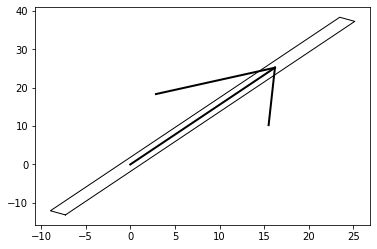

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
PI = np.pi


class Arrow:
    def __init__(self, x, y, theta, L, c):
        angle = np.deg2rad(30)
        d = 0.5 * L
        w = 2

        x_start = x
        y_start = y
        x_end = x + L * np.cos(theta)
        y_end = y + L * np.sin(theta)

        theta_hat_L = theta + PI - angle
        theta_hat_R = theta + PI + angle

        x_hat_start = x_end
        x_hat_end_L = x_hat_start + d * np.cos(theta_hat_L)
        x_hat_end_R = x_hat_start + d * np.cos(theta_hat_R)

        y_hat_start = y_end
        y_hat_end_L = y_hat_start + d * np.sin(theta_hat_L)
        y_hat_end_R = y_hat_start + d * np.sin(theta_hat_R)

        plt.plot([x_start, x_end], [y_start, y_end], color=c, linewidth=w)
        plt.plot([x_hat_start, x_hat_end_L],
                 [y_hat_start, y_hat_end_L], color=c, linewidth=w)
        plt.plot([x_hat_start, x_hat_end_R],
                 [y_hat_start, y_hat_end_R], color=c, linewidth=w)


class Car:
    def __init__(self, x, y, yaw, w, L):
        theta_B = PI + yaw

        xB = x + L / 4 * np.cos(theta_B)
        yB = y + L / 4 * np.sin(theta_B)

        theta_BL = theta_B + PI / 2
        theta_BR = theta_B - PI / 2

        x_BL = xB + w / 2 * np.cos(theta_BL)        # Bottom-Left vertex
        y_BL = yB + w / 2 * np.sin(theta_BL)
        x_BR = xB + w / 2 * np.cos(theta_BR)        # Bottom-Right vertex
        y_BR = yB + w / 2 * np.sin(theta_BR)

        x_FL = x_BL + L * np.cos(yaw)               # Front-Left vertex
        y_FL = y_BL + L * np.sin(yaw)
        x_FR = x_BR + L * np.cos(yaw)               # Front-Right vertex
        y_FR = y_BR + L * np.sin(yaw)

        plt.plot([x_BL, x_BR, x_FR, x_FL, x_BL],
                 [y_BL, y_BR, y_FR, y_FL, y_BL],
                 linewidth=1, color='black')

        Arrow(x, y, yaw, L / 2, 'black')
        # plt.axis("equal")
        # plt.show()


if __name__ == '__main__':
    # Arrow(-1, 2, 60)
    Car(0, 0, 1, 2, 60)

In [ ]:
"""
Dubins Path


import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot



# class for PATH element
class PATH:
    def __init__(self, L, mode, x, y, yaw):
        self.L = L  # total path length [float]
        self.mode = mode  # type of each part of the path [string]
        self.x = x  # final x positions [m]
        self.y = y  # final y positions [m]
        self.yaw = yaw  # final yaw angles [rad]


# utils
def pi_2_pi(theta):
    while theta > math.pi:
        theta -= 2.0 * math.pi

    while theta < -math.pi:
        theta += 2.0 * math.pi

    return theta


def mod2pi(theta):
    return theta - 2.0 * math.pi * math.floor(theta / math.pi / 2.0)


def LSL(alpha, beta, dist):
    sin_a = math.sin(alpha)
    sin_b = math.sin(beta)
    cos_a = math.cos(alpha)
    cos_b = math.cos(beta)
    cos_a_b = math.cos(alpha - beta)

    p_lsl = 2 + dist ** 2 - 2 * cos_a_b + 2 * dist * (sin_a - sin_b)

    if p_lsl < 0:
        return None, None, None, ["L", "S", "L"]
    else:
        p_lsl = math.sqrt(p_lsl)

    denominate = dist + sin_a - sin_b
    t_lsl = mod2pi(-alpha + math.atan2(cos_b - cos_a, denominate))
    q_lsl = mod2pi(beta - math.atan2(cos_b - cos_a, denominate))

    return t_lsl, p_lsl, q_lsl, ["L", "S", "L"]


def RSR(alpha, beta, dist):
    sin_a = math.sin(alpha)
    sin_b = math.sin(beta)
    cos_a = math.cos(alpha)
    cos_b = math.cos(beta)
    cos_a_b = math.cos(alpha - beta)

    p_rsr = 2 + dist ** 2 - 2 * cos_a_b + 2 * dist * (sin_b - sin_a)

    if p_rsr < 0:
        return None, None, None, ["R", "S", "R"]
    else:
        p_rsr = math.sqrt(p_rsr)

    denominate = dist - sin_a + sin_b
    t_rsr = mod2pi(alpha - math.atan2(cos_a - cos_b, denominate))
    q_rsr = mod2pi(-beta + math.atan2(cos_a - cos_b, denominate))

    return t_rsr, p_rsr, q_rsr, ["R", "S", "R"]


def LSR(alpha, beta, dist):
    sin_a = math.sin(alpha)
    sin_b = math.sin(beta)
    cos_a = math.cos(alpha)
    cos_b = math.cos(beta)
    cos_a_b = math.cos(alpha - beta)

    p_lsr = -2 + dist ** 2 + 2 * cos_a_b + 2 * dist * (sin_a + sin_b)

    if p_lsr < 0:
        return None, None, None, ["L", "S", "R"]
    else:
        p_lsr = math.sqrt(p_lsr)

    rec = math.atan2(-cos_a - cos_b, dist + sin_a + sin_b) - math.atan2(-2.0, p_lsr)
    t_lsr = mod2pi(-alpha + rec)
    q_lsr = mod2pi(-mod2pi(beta) + rec)

    return t_lsr, p_lsr, q_lsr, ["L", "S", "R"]


def RSL(alpha, beta, dist):
    sin_a = math.sin(alpha)
    sin_b = math.sin(beta)
    cos_a = math.cos(alpha)
    cos_b = math.cos(beta)
    cos_a_b = math.cos(alpha - beta)

    p_rsl = -2 + dist ** 2 + 2 * cos_a_b - 2 * dist * (sin_a + sin_b)

    if p_rsl < 0:
        return None, None, None, ["R", "S", "L"]
    else:
        p_rsl = math.sqrt(p_rsl)

    rec = math.atan2(cos_a + cos_b, dist - sin_a - sin_b) - math.atan2(2.0, p_rsl)
    t_rsl = mod2pi(alpha - rec)
    q_rsl = mod2pi(beta - rec)

    return t_rsl, p_rsl, q_rsl, ["R", "S", "L"]


def RLR(alpha, beta, dist):
    sin_a = math.sin(alpha)
    sin_b = math.sin(beta)
    cos_a = math.cos(alpha)
    cos_b = math.cos(beta)
    cos_a_b = math.cos(alpha - beta)

    rec = (6.0 - dist ** 2 + 2.0 * cos_a_b + 2.0 * dist * (sin_a - sin_b)) / 8.0

    if abs(rec) > 1.0:
        return None, None, None, ["R", "L", "R"]

    p_rlr = mod2pi(2 * math.pi - math.acos(rec))
    t_rlr = mod2pi(alpha - math.atan2(cos_a - cos_b, dist - sin_a + sin_b) + mod2pi(p_rlr / 2.0))
    q_rlr = mod2pi(alpha - beta - t_rlr + mod2pi(p_rlr))

    return t_rlr, p_rlr, q_rlr, ["R", "L", "R"]


def LRL(alpha, beta, dist):
    sin_a = math.sin(alpha)
    sin_b = math.sin(beta)
    cos_a = math.cos(alpha)
    cos_b = math.cos(beta)
    cos_a_b = math.cos(alpha - beta)

    rec = (6.0 - dist ** 2 + 2.0 * cos_a_b + 2.0 * dist * (sin_b - sin_a)) / 8.0

    if abs(rec) > 1.0:
        return None, None, None, ["L", "R", "L"]

    p_lrl = mod2pi(2 * math.pi - math.acos(rec))
    t_lrl = mod2pi(-alpha - math.atan2(cos_a - cos_b, dist + sin_a - sin_b) + p_lrl / 2.0)
    q_lrl = mod2pi(mod2pi(beta) - alpha - t_lrl + mod2pi(p_lrl))

    return t_lrl, p_lrl, q_lrl, ["L", "R", "L"]


def interpolate(ind, l, m, maxc, ox, oy, oyaw, px, py, pyaw, directions):
    if m == "S":
        px[ind] = ox + l / maxc * math.cos(oyaw)
        py[ind] = oy + l / maxc * math.sin(oyaw)
        pyaw[ind] = oyaw
    else:
        ldx = math.sin(l) / maxc
        if m == "L":
            ldy = (1.0 - math.cos(l)) / maxc
        elif m == "R":
            ldy = (1.0 - math.cos(l)) / (-maxc)

        gdx = math.cos(-oyaw) * ldx + math.sin(-oyaw) * ldy
        gdy = -math.sin(-oyaw) * ldx + math.cos(-oyaw) * ldy
        px[ind] = ox + gdx
        py[ind] = oy + gdy

    if m == "L":
        pyaw[ind] = oyaw + l
    elif m == "R":
        pyaw[ind] = oyaw - l

    if l > 0.0:
        directions[ind] = 1
    else:
        directions[ind] = -1

    return px, py, pyaw, directions


def generate_local_course(L, lengths, mode, maxc, step_size):
    point_num = int(L / step_size) + len(lengths) + 3

    px = [0.0 for _ in range(point_num)]
    py = [0.0 for _ in range(point_num)]
    pyaw = [0.0 for _ in range(point_num)]
    directions = [0 for _ in range(point_num)]
    ind = 1

    if lengths[0] > 0.0:
        directions[0] = 1
    else:
        directions[0] = -1

    if lengths[0] > 0.0:
        d = step_size
    else:
        d = -step_size

    ll = 0.0

    for m, l, i in zip(mode, lengths, range(len(mode))):
        if l > 0.0:
            d = step_size
        else:
            d = -step_size

        ox, oy, oyaw = px[ind], py[ind], pyaw[ind]

        ind -= 1
        if i >= 1 and (lengths[i - 1] * lengths[i]) > 0:
            pd = -d - ll
        else:
            pd = d - ll

        while abs(pd) <= abs(l):
            ind += 1
            px, py, pyaw, directions = \
                interpolate(ind, pd, m, maxc, ox, oy, oyaw, px, py, pyaw, directions)
            pd += d

        ll = l - pd - d  # calc remain length

        ind += 1
        px, py, pyaw, directions = \
            interpolate(ind, l, m, maxc, ox, oy, oyaw, px, py, pyaw, directions)

    if len(px) <= 1:
        return [], [], [], []

    # remove unused data
    while len(px) >= 1 and px[-1] == 0.0:
        px.pop()
        py.pop()
        pyaw.pop()
        directions.pop()

    return px, py, pyaw, directions


def planning_from_origin(gx, gy, gyaw, curv, step_size):
    D = math.hypot(gx, gy)
    d = D * curv

    theta = mod2pi(math.atan2(gy, gx))
    alpha = mod2pi(-theta)
    beta = mod2pi(gyaw - theta)

    planners = [LSL, RSR, LSR, RSL, RLR, LRL]

    best_cost = float("inf")
    bt, bp, bq, best_mode = None, None, None, None

    for planner in planners:
        t, p, q, mode = planner(alpha, beta, d)

        if t is None:
            continue

        cost = (abs(t) + abs(p) + abs(q))
        if best_cost > cost:
            bt, bp, bq, best_mode = t, p, q, mode
            best_cost = cost
    lengths = [bt, bp, bq]

    x_list, y_list, yaw_list, directions = generate_local_course(
        sum(lengths), lengths, best_mode, curv, step_size)

    return x_list, y_list, yaw_list, best_mode, best_cost


def calc_dubins_path(sx, sy, syaw, gx, gy, gyaw, curv, step_size=0.1):
    gx = gx - sx
    gy = gy - sy

    l_rot = Rot.from_euler('z', syaw).as_dcm()[0:2, 0:2]
    le_xy = np.stack([gx, gy]).T @ l_rot
    le_yaw = gyaw - syaw

    lp_x, lp_y, lp_yaw, mode, lengths = planning_from_origin(
        le_xy[0], le_xy[1], le_yaw, curv, step_size)

    rot = Rot.from_euler('z', -syaw).as_dcm()[0:2, 0:2]
    converted_xy = np.stack([lp_x, lp_y]).T @ rot
    x_list = converted_xy[:, 0] + sx
    y_list = converted_xy[:, 1] + sy
    yaw_list = [pi_2_pi(i_yaw + syaw) for i_yaw in lp_yaw]

    return PATH(lengths, mode, x_list, y_list, yaw_list)


def main(states):
    # choose states pairs: (x, y, yaw)
    # simulation-1
    #states = [(0, 0, 0), (10, 10, -90), (20, 5, 60), (30, 10, 120),
    #          (35, -5, 30), (25, -10, -120), (15, -15, 100), (0, -10, -90)]

    # simulation-2
    # states = [(-3, 3, 120), (10, -7, 30), (10, 13, 30), (20, 5, -25),
    #           (35, 10, 180), (32, -10, 180), (5, -12, 90)]
    max_c=1
    #max_c = 0.25  # max curvature
    path_x, path_y, yaw = [], [], []

    for i in range(len(states) - 1):
        s_x = states[i][0]
        s_y = states[i][1]
        s_yaw = np.deg2rad(states[i][2])
        g_x = states[i + 1][0]
        g_y = states[i + 1][1]
        g_yaw = np.deg2rad(states[i + 1][2])

        path_i = calc_dubins_path(s_x, s_y, s_yaw, g_x, g_y, g_yaw, max_c)

        for x, y, iyaw in zip(path_i.x, path_i.y, path_i.yaw):
            path_x.append(x)
            path_y.append(y)
            yaw.append(iyaw)

    # animation
    plt.ion()
    plt.figure(1)

    for i in range(len(path_x)):
        plt.clf()
        plt.plot(path_x, path_y, linewidth=1, color='gray')

        ##aggiunta+++++++++++
        plt.scatter(X, Y, s=area, c=colors, alpha=0.5)
        #++++++++++++++++
        for x, y, theta in states:
            Arrow(x, y, np.deg2rad(theta), 1, 'blueviolet')

        Car(path_x[i], path_y[i], yaw[i], 0.5, 0.6)

        plt.axis("equal")
        plt.title("Simulation of Dubins Path")
        plt.axis([-7, 7, -3, 7])
        plt.draw()
        plt.pause(0.001)

    plt.pause(1)

"""

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:282: DeprecationWarning: `as_dcm` is deprecated!
as_dcm is renamed to as_matrix in scipy 1.4.0 and will be removed in scipy 1.6.0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:289: DeprecationWarning: `as_dcm` is deprecated!
as_dcm is renamed to as_matrix in scipy 1.4.0 and will be removed in scipy 1.6.0


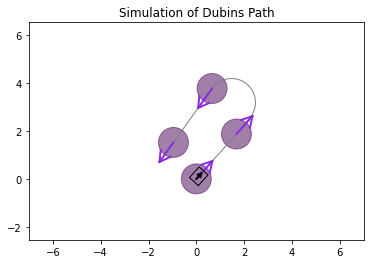

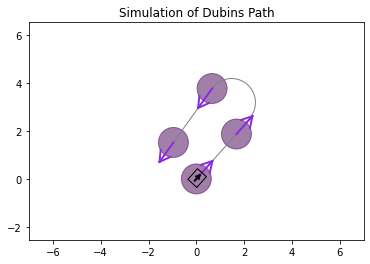

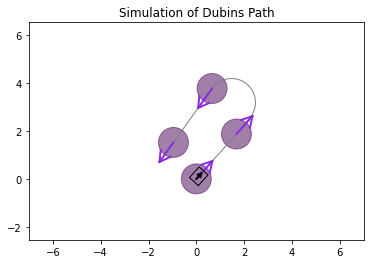

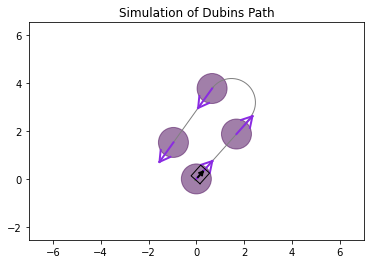

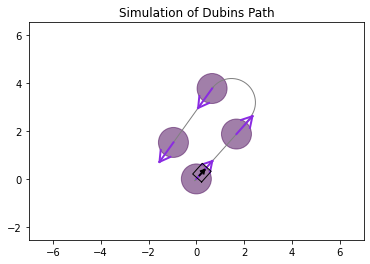

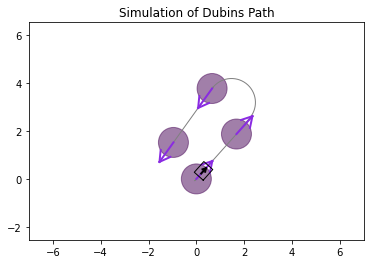

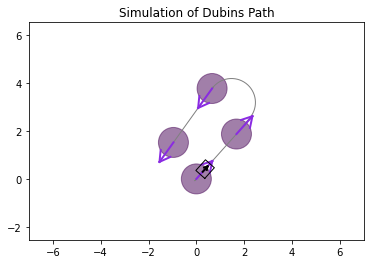

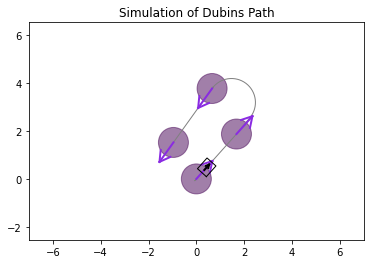

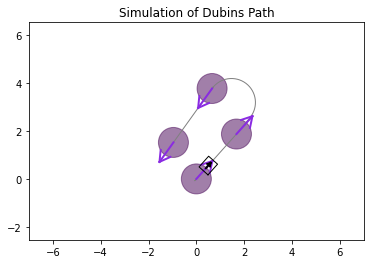

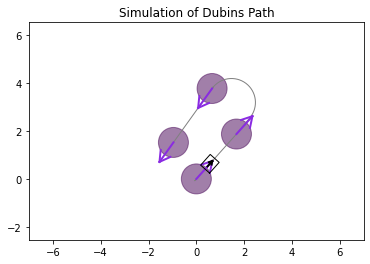

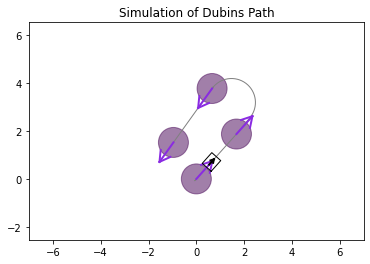

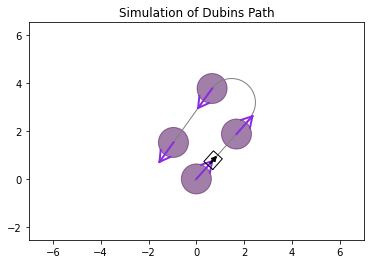

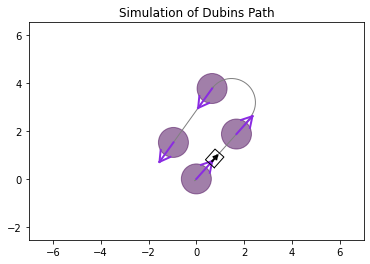

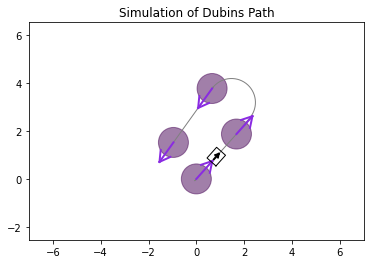

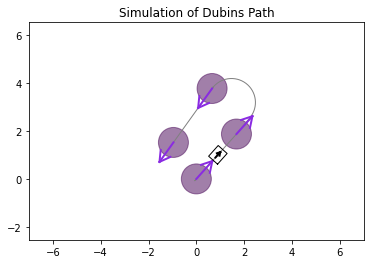

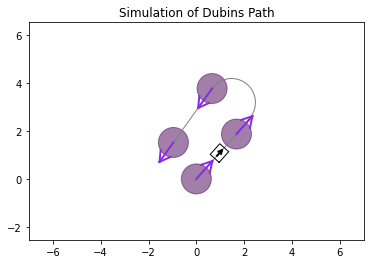

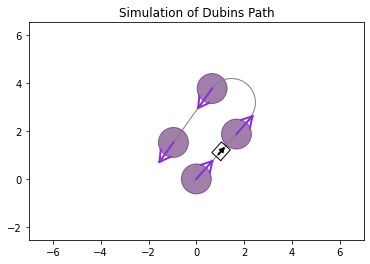

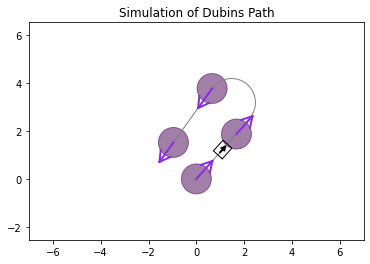

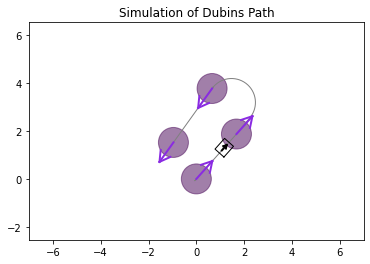

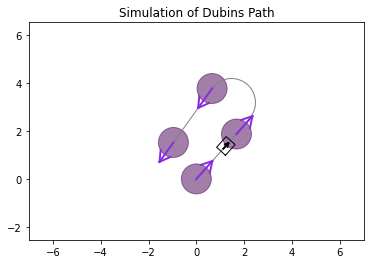

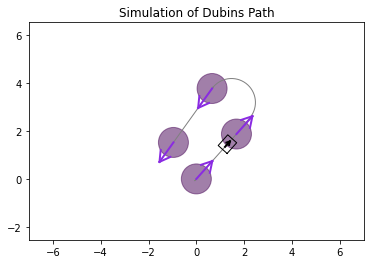

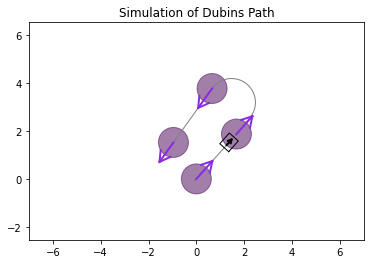

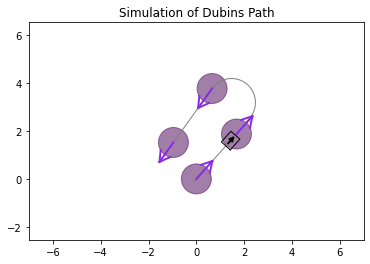

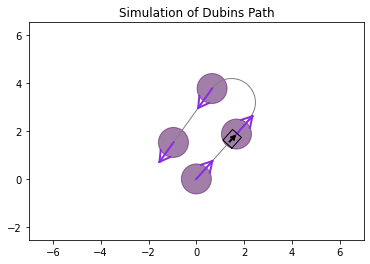

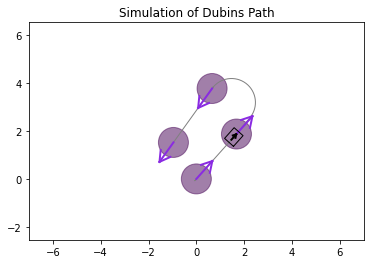

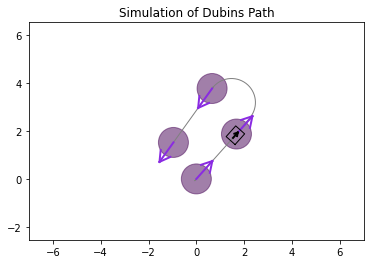

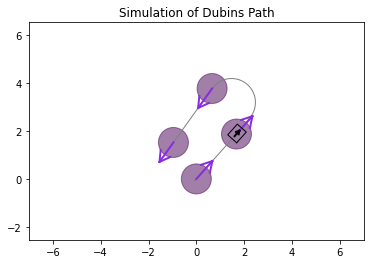

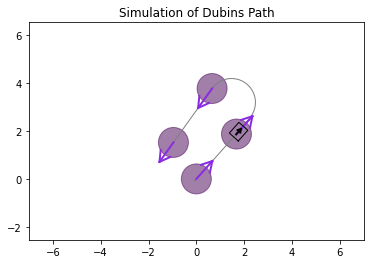

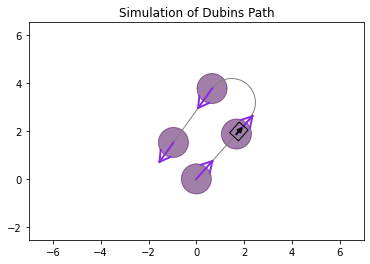

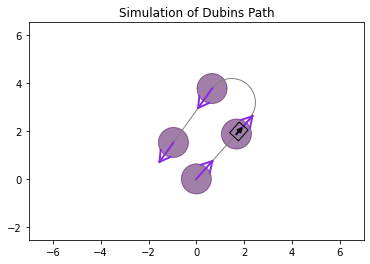

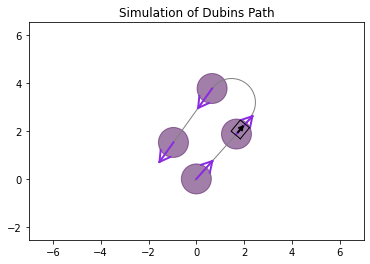

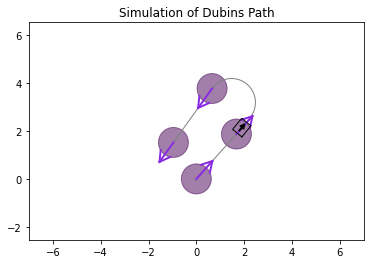

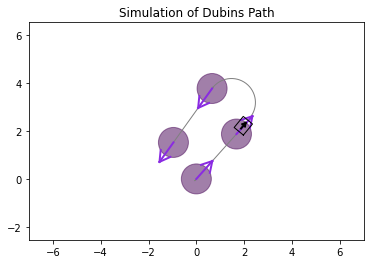

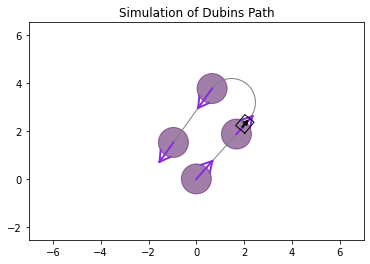

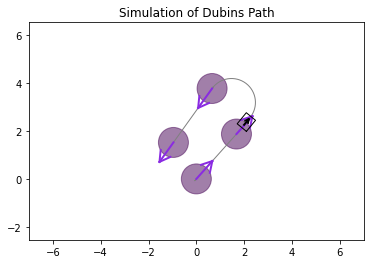

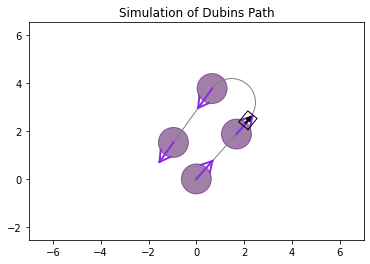

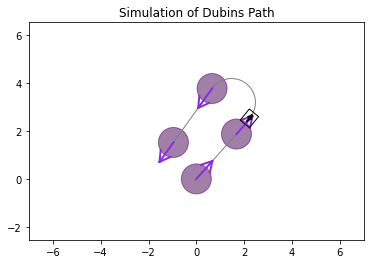

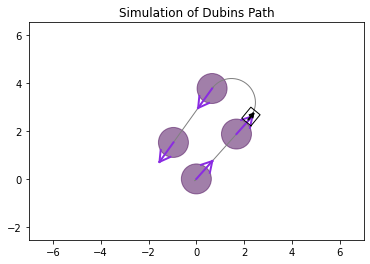

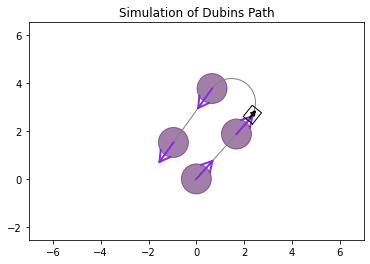

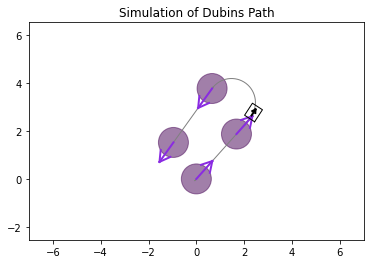

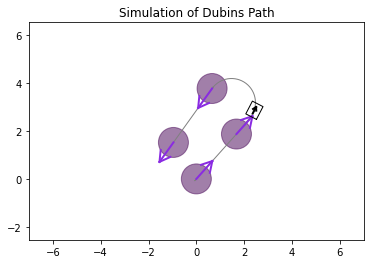

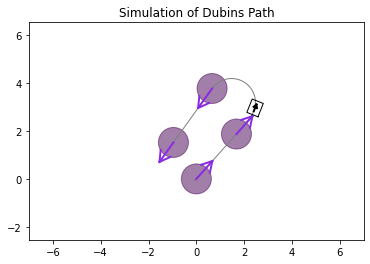

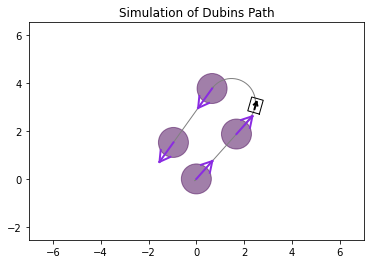

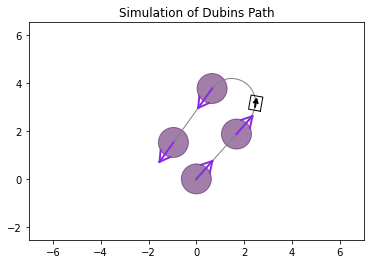

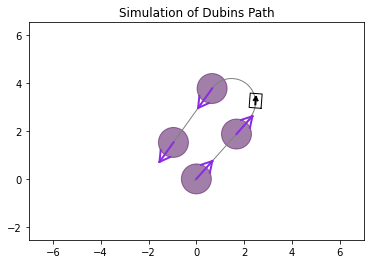

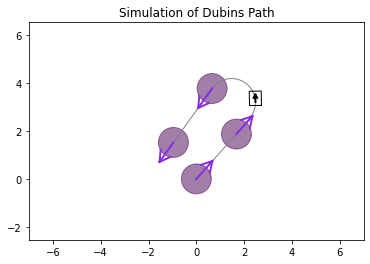

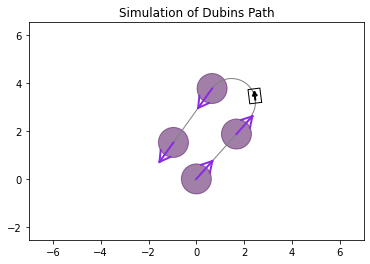

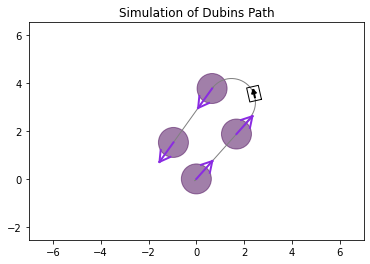

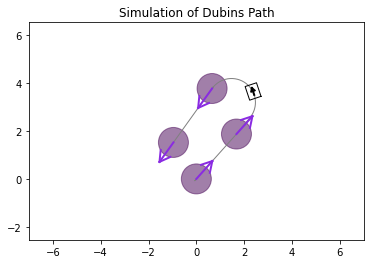

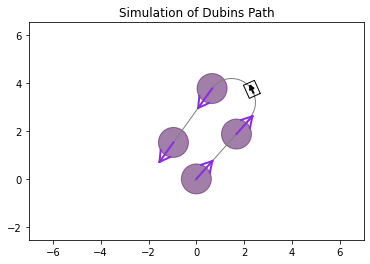

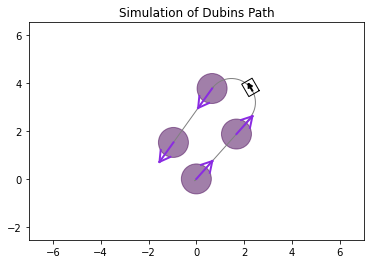

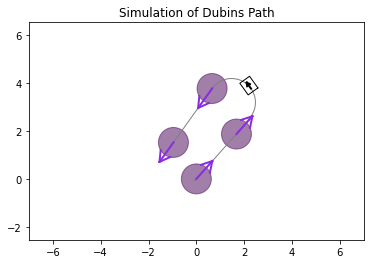

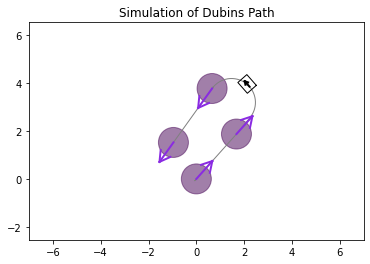

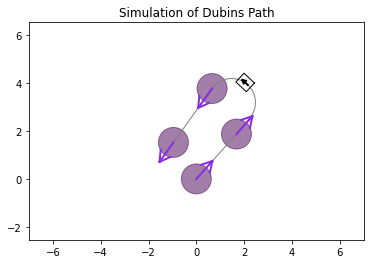

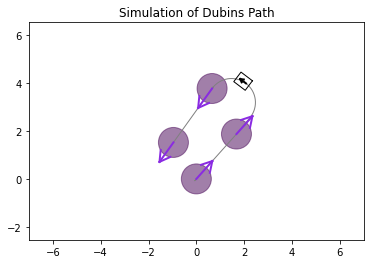

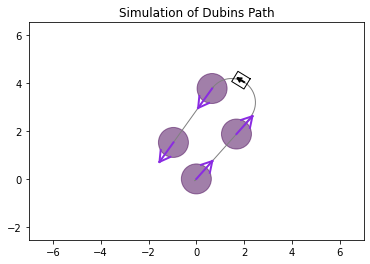

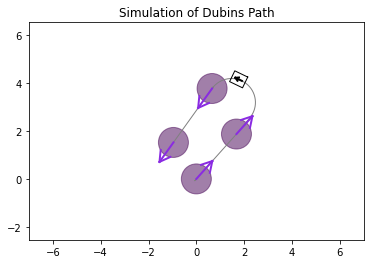

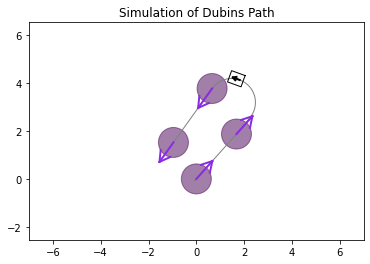

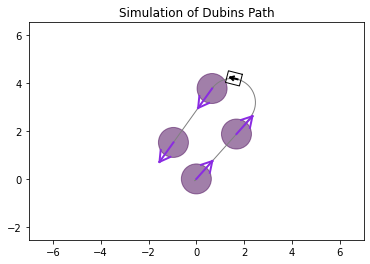

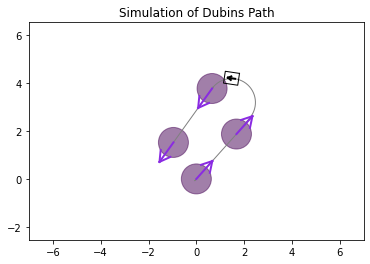

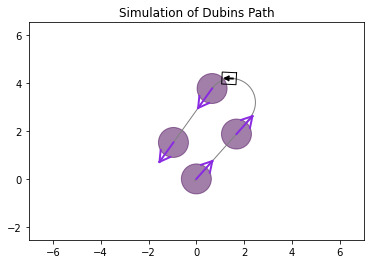

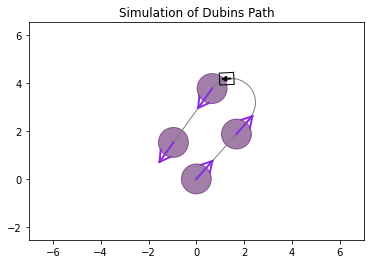

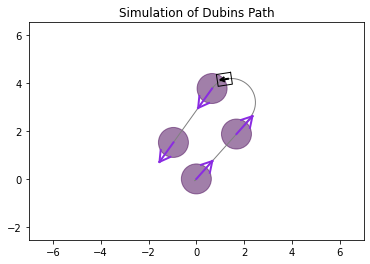

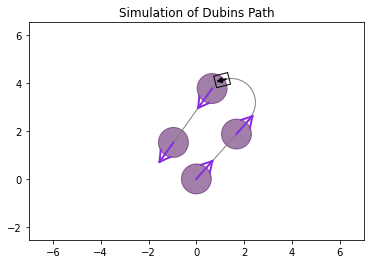

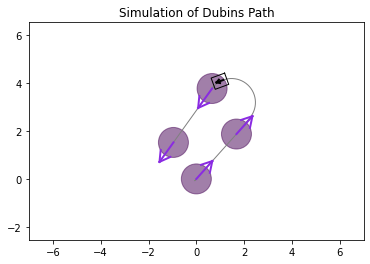

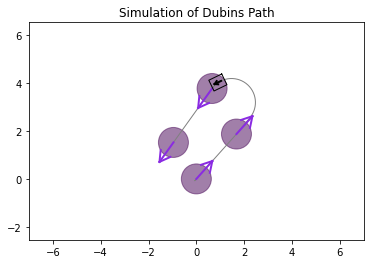

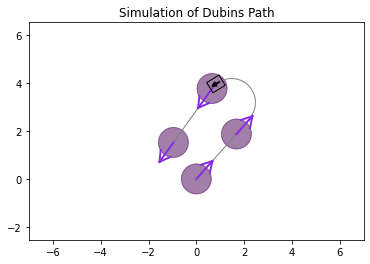

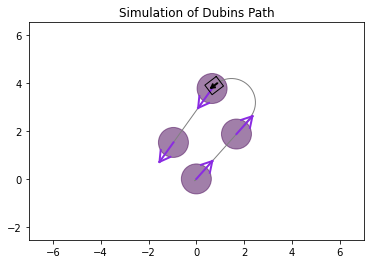

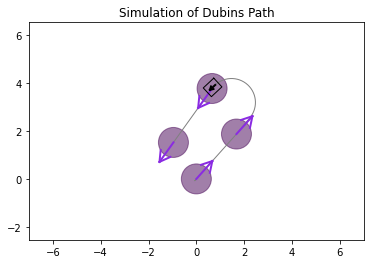

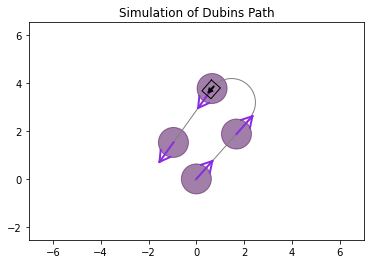

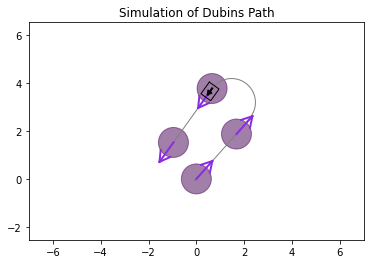

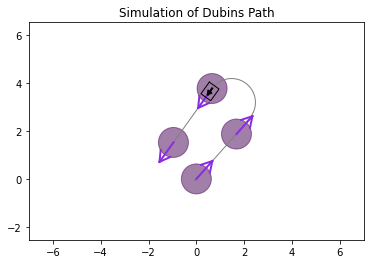

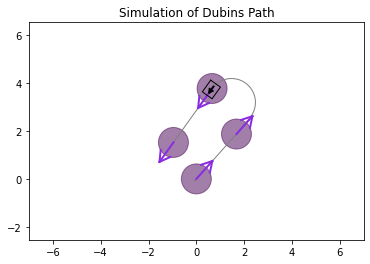

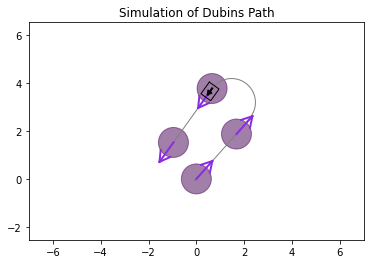

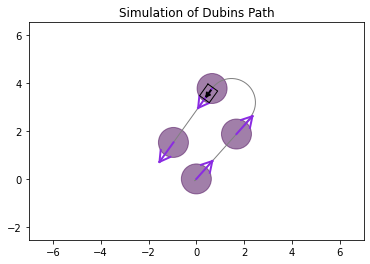

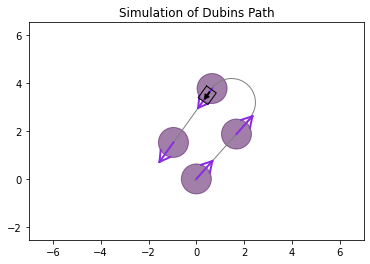

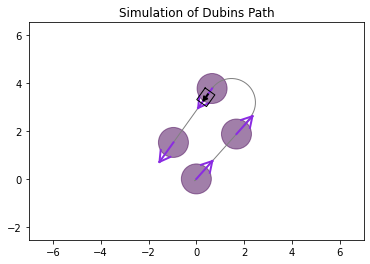

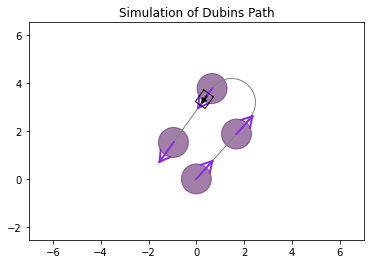

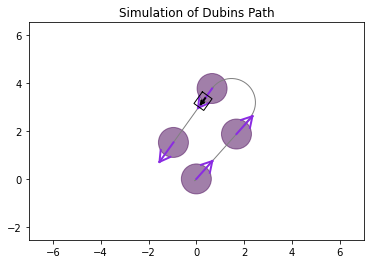

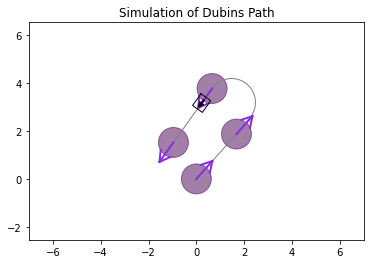

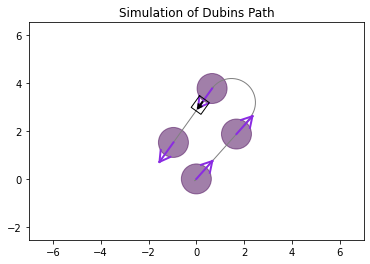

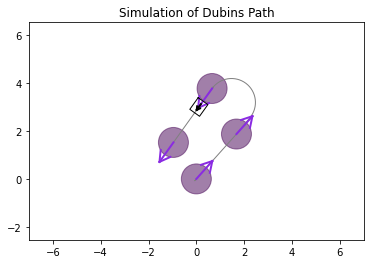

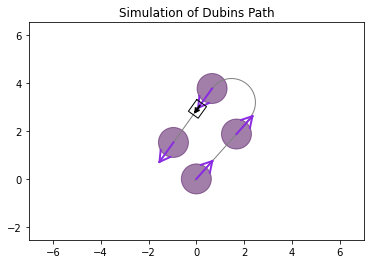

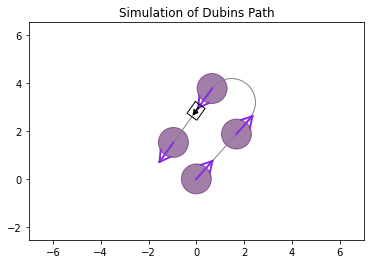

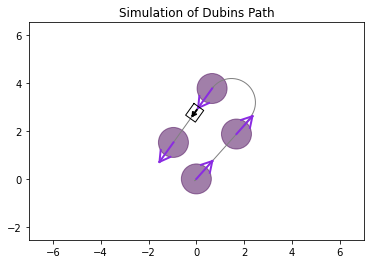

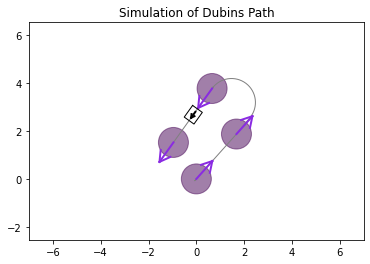

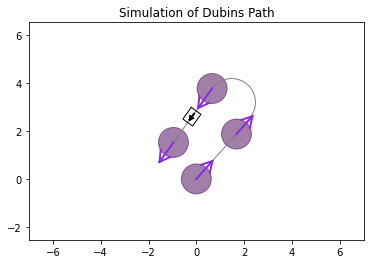

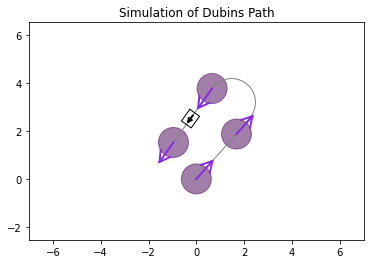

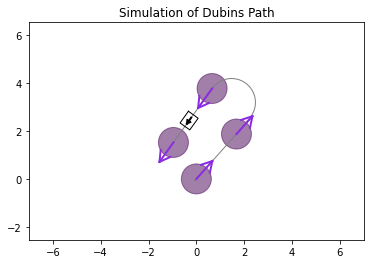

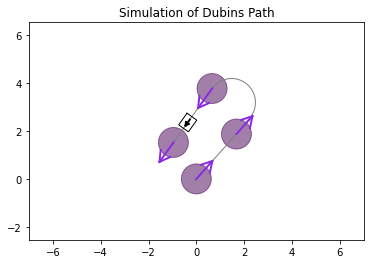

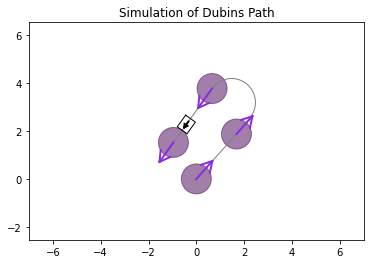

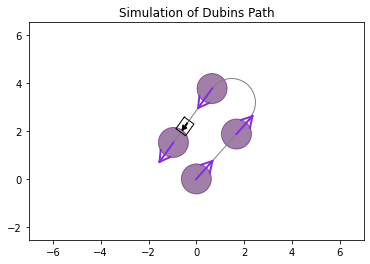

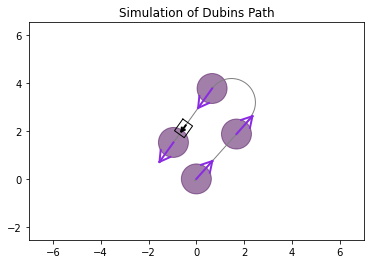

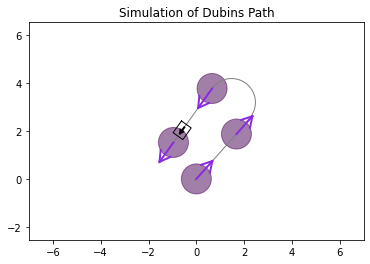

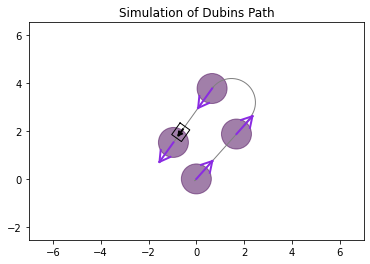

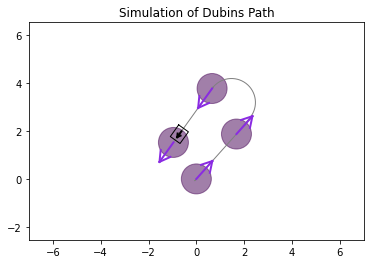

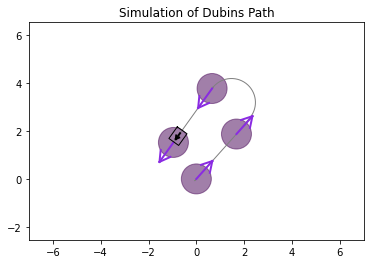

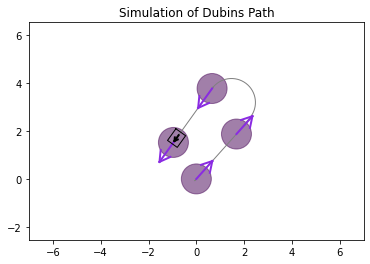

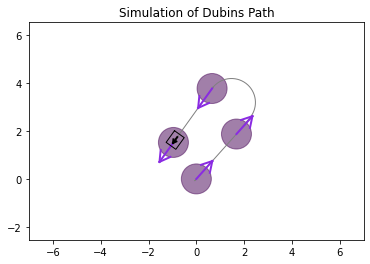

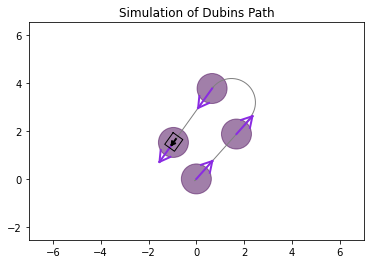

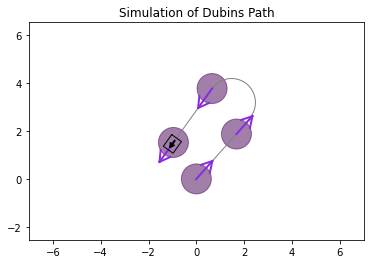

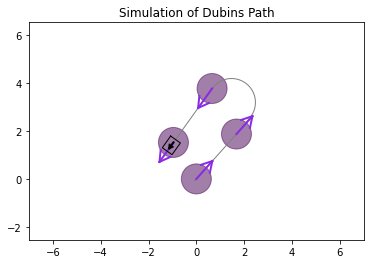

In [ ]:

if __name__ == '__main__':
    main(statoni)